In [11]:
import gym
from easy21_env import Easy21
import numpy as np
from pprint import pprint

import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

sns.set('notebook', font_scale=1.1, rc={ 'figure.figsize': (6, 3) })
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

### 1 Implementation of Easy21

You should write an environment that implements the game Easy21. Specifically, write a function, named `step`, which takes as input a state $s$ (dealer’s first card 1–10 and the player’s sum 1–21), and an action $a$ (`hit` or `stick`), and returns a sample of the next state $s′$ (which may be terminal if the game is finished) and reward $r$. We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the **transition matrix** for the MDP. There is no discounting ($\gamma = 1$). You should treat the dealer’s moves as part of the environment, i.e. calling step with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [12]:
num_episodes = 50
# Initialize environment with fixed policies for the dealer and the player
env = Easy21(dealer_threshold=17, player_threshold=12)
rewards_seq = np.zeros(num_episodes)

for episode_i in range(num_episodes):

    # Reset environment
    obs, _, done, info = env._reset()

    trajec = list()

    while not done:

        if obs[1] < env.player_threshold:
            action = 1 
        else:  
            action = 0

        # Take a step
        obs, reward, done, info = env.step(action)
                
        trajec.append((obs, action, reward))
    
    rewards_seq[episode_i] = reward

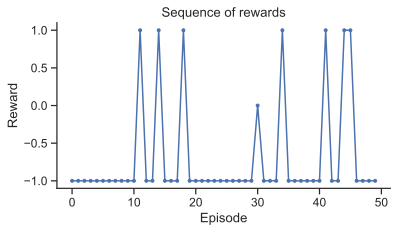

In [13]:
plt.title('Sequence of rewards')
plt.plot(rewards_seq, '.-')
plt.xlabel('Episode')
plt.ylabel('Reward')
sns.despine()

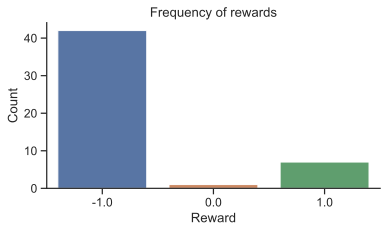

In [14]:
df = pd.DataFrame({'rewards_seq': rewards_seq})

plt.title('Frequency of rewards')
sns.countplot(x='rewards_seq', data=df)
plt.xlabel('Reward')
plt.ylabel('Count')
sns.despine()

### 2 Monte Carlo control

Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use a time-varying scalar step-size of 
\begin{align*}
    \alpha_t = 1/N(s_t, a_t)
\end{align*}
and an $\epsilon$-greedy exploration strategy with 
\begin{align*}
    \epsilon_t = N_0 \, / \, (N_0 + N(s_t)) 
\end{align*}
where $N_0 = 100$ is a constant, $N(s)$ is the number of times that state $s$ has been visited, and $N(s,a)$ is the number of times that action a has been selected from state $s$. Feel free to choose an alternative value for $N_0$, if it helps producing better results. Plot the optimal value function 
\begin{align*}
    V^{*}(s) = \text{max}_{a} \, \, Q^{*} (s, a)
\end{align*}
using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

---

We implement the monte carlo algorithm below and plot the optimal value function.

In [15]:
class BaseAlgo:
    """Base class for Reinforcement Learning algorithms.
    """
    def __init__(self, env_dim, N0=100): 
        self.Q_table = np.zeros(env_dim) # Store the value of that state
        self.N_table = np.zeros(env_dim) # Store the number of times we've visited the state (count each visit)
        self.N0 = N0
        self.env_dim = env_dim

    def to_index(self, obs, action=-1):
        """Get indices to store N and Q values.

        Args:
            obs (Tuple): Observation containing (dealer card, sum of player cards)
            action (int, optional): The action that was taken. If not given, defaults to -1.

        Returns:
            indices (Tuple): Indices to store in lookup table.
        """
        return obs[0] - 1, obs[1] - 1, action
        
    def take_eps_greedy_action(self, obs):
        """Take action with randomness.

        Args:
            obs (Tuple): Observation containing (dealer card, sum of player cards)

        Returns:
            action (int): An action
        """
        # Count how many times state is visited
        N_st = np.sum(self.N_table[self.to_index(obs, -1)])
        # Compute epsilon
        eps = self.N0 / (self.N0 + N_st)

        if (1 - eps) < np.random.rand():
            # Random
            action = 1
        else:
            action = 0
        # Store in table
        self.N_table[self.to_index(obs, action)] += 1
        return action

class MonteCarlo(BaseAlgo):
    """Monte Carlo Prediction.
    """

    def update_policy(self, trajectory):
        """Update the policy based on experience.

        Args:
            trajectory (Tuple of lists): A tuple containing (state, action, reward) 
            for each step in an episode.
        """
        # Take the reward at the end of the game
        reward = trajectory[-1][2]

        for obs, action, _ in trajectory:
            # Adapt learning rate
            if self.N_table[self.to_index(obs, action)] != 0:
                alpha = 1 / self.N_table[self.to_index(obs, action)]
            else: 
                alpha = 1
            # Update q value         
            self.Q_table[self.to_index(obs, action)] += alpha * reward

In [30]:
num_episodes = 500_000

# Initialize environment
easy21 = Easy21(dealer_threshold=17, player_threshold=12)

# Initialize Monte Carlo algorithm
monte_carlo_learner = MonteCarlo(easy21.dim)

for episode_i in range(num_episodes):
    trajectory = list()

    obs, _, done, info = easy21._reset()

    while not done:
        if obs[1] < env.player_threshold: # Play with fixed policy
            # Always hit
            action = 1 
        else:  
            # Take epsilon greedy action
            action = monte_carlo_learner.take_eps_greedy_action(obs)
            
        # Get new observation
        new_obs, reward, done, info = easy21.step(action)
        obs = new_obs

        # Store trajectory
        trajectory.append((obs, action, reward))
    
    # Update the policy at the end of the episode
    monte_carlo_learner.update_policy(trajectory)

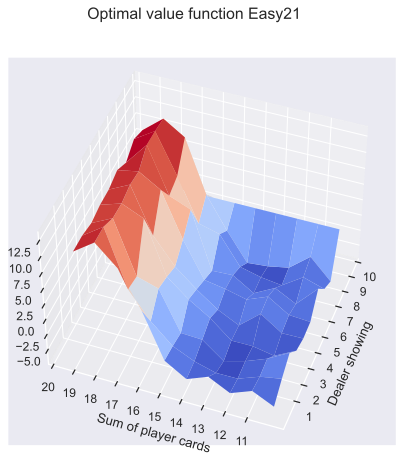

In [31]:
sns.set('notebook', font_scale=1.1, rc={ 'figure.figsize': (9, 7) })

X, Y = np.meshgrid(np.arange(10), np.arange(10))                   
Z = monte_carlo_learner.Q_table.max(axis=2).transpose()[11:, :]

fig = plt.figure()
fig.suptitle('Optimal value function Easy21')
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel('Dealer showing')
ax.set_ylabel('Sum of player cards')
ax.view_init(45, 200)
ax.set_xticks(range(1, 11));
ax.set_yticks(range(1, 11));
ax.set_yticklabels(range(11, 21));